# **Binary Matrix Factorization Algorithm**

Matrix factorization is a collaborative filtering method used to predict missing entries in the user-item interaction matrix by decomposing it into two low-dimensional matrices:  Q (user embeddings) and P (item embeddings).

    https://web.stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf


##### Initialize Matrices
- Randomly initialize  Q  and  P 
- Alternatively, use metadata embeddings to initialize these matrices.

---

##### Optimize for Loss Function
For binary interaction, we define the predicted probability of interaction $\hat{r}_{ui}$ using the sigmoid function:
$$
\hat{r}_{ui} = \sigma(\mathbf{q}_i^\top \mathbf{p}_u) = \frac{1}{1 + e^{-\mathbf{q}_i^\top \mathbf{p}_u}}
$$

The binary cross-entropy loss becomes:
$$
L = -\sum_{(u, i) \in R} \left( r_{ui} \log(\hat{r}_{ui}) + (1 - r_{ui}) \log(1 - \hat{r}_{ui}) \right) 
+ \lambda \left( \|\mathbf{q}_i\|^2 + \|\mathbf{p}_u\|^2 \right)
$$

Where:
- $r_{ui} \in \{0, 1\}$ is the observed interaction (binary).
- $\hat{r}_{ui}$ is the predicted probability of interaction.
- $\lambda$ is the regularization parameter.




##### Iterative Updates
- Update Q and P alternately to minimize the loss function L.
- Common optimization techniques include:
  
  
  - **Alternating Least Squares (ALS):**
  
    - Fix P and solve for Q, then fix Q and solve for P.
  
  - **Stochastic Gradient Descent (SGD):**
  
    - Update Q and P by iteratively taking gradient steps on L.

---

##### Output
- Q : Captures user preferences in a latent space.
- P : Captures item characteristics in the same latent space.

The predicted rating for user  i and item j is given by:

$$
\hat{R}_{ij} = Q_i \cdot P_j^\top
$$


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
# Charger les données (FOR THE BINARY)
df_recommendation = pd.read_csv("data/musical_instruments_20_20.csv")
ratings = df_recommendation[['user', 'id', 'rating']]

# Création des mappings utilisateur-item
user_ids = ratings['user'].unique()
item_ids = ratings['id'].unique()
user_id_map = {id: idx for idx, id in enumerate(user_ids)}
item_id_map = {id: idx for idx, id in enumerate(item_ids)}

ratings['user_idx'] = ratings['user'].map(user_id_map)
ratings['item_idx'] = ratings['id'].map(item_id_map)


# load test and train sets : 
train = pd.read_csv("data/train.csv") # ici on entraine sur la maytrice complete 
train['user_idx'] = train['user'].map(user_id_map)
train['item_idx'] = train['id'].map(item_id_map)

test = pd.read_csv("data/test_negative_transformed.csv")


##### Loss function $\mathbf{L}$ :

$$
L = -\sum_{(u, i) \in R} \left( r_{ui} \log(\hat{r}_{ui}) + (1 - r_{ui}) \log(1 - \hat{r}_{ui}) \right) 
+ \lambda \left( \|\mathbf{q}_i\|^2 + \|\mathbf{p}_u\|^2 \right)
$$


**Derivative with Respect to $\mathbf{p}_u$:**

The derivative of the loss $L$ with respect to $\mathbf{p}_u$ is:
$$
\frac{\partial L}{\partial \mathbf{p}_u} = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui}) \mathbf{q}_i + 2\lambda \mathbf{p}_u
$$

Here:
- $(\hat{r}_{ui} - r_{ui})$ is the prediction error for the binary cross-entropy.

**Derivative with Respect to $\mathbf{q}_i$:**

Similarly, the derivative with respect to $\mathbf{q}_i$ is:
$$
\frac{\partial L}{\partial \mathbf{q}_i} = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui}) \mathbf{p}_u + 2\lambda \mathbf{q}_i
$$

##### **1rst Training  with fixed regularization term on latent vectors** : 
##### Optimizer : Gradient descent algo

In [3]:
train.head(2)

,user,id,rating,timestamp,user_idx,item_idx
0,0,645,1.0,1361730191000,0,6
1,0,30,1.0,1427926325000,0,0


In [4]:
test.head(2)

,user,id1,rating1,id2,rating2,timestamp1,timestamp2,negative_1,negative_2,negative_3,...,negative_90,negative_91,negative_92,negative_93,negative_94,negative_95,negative_96,negative_97,negative_98,negative_99
0,0,636.0,1.0,770.0,1.0,1.633611e+12,1.642465e+12,533,885,863,...,139,40,437,177,271,834,608,407,99,587
1,1,904.0,1.0,658.0,1.0,1.651027e+12,1.664305e+12,542,692,729,...,850,561,540,341,538,976,288,567,91,594


### **Metrics definition ( Accuracy , Average loss, HR, NDCG) :**


In [5]:
def sigmoid(x):
    """
    Compute the sigmoid function.
    """
    return 1 / (1 + np.exp(-x))


def prediction_interaction(user_id, item_id, P, Q, verbose=True):
    # Get the indices for user and item
    user_idx = user_id_map[user_id]  # Map user_id to the corresponding index
    item_idx = item_id_map[item_id]  # Map item_id to the corresponding index

    # Predicted probability using sigmoid
    predicted_interaction = sigmoid(np.dot(P[user_idx], Q[item_idx]))  # Probability of interaction

    if verbose:
        print(f"Predicted Probability of Interaction for user-item pair: {predicted_interaction:.4f}")

    return predicted_interaction

####    **Evaluation with the leave - 2 - out (HR and NDCG) :**
#### General approach:

For each user in the test game, we have:

- The positive element (in id).

- The 99 negative elements (in negative_1, ..., negative_99).

The predictions for these 100 elements (1 positive + 99 negative) are calculated using the prediction_rating function.

We sort the elements according to the predicted scores. HR and NDCG are evaluated on the top-K elements.

In [6]:

def evaluate_model_binary(test_data, P, Q, threshold=0.5, verbose=False):
    total_accuracy = 0
    total_loss = 0
    num_test_samples = len(test_data)

    for _, row in test_data.iterrows():
        u, i, r_ui = int(row['user_idx']), int(row['item_idx']), int(row['rating'])
        
        # Predicted probability using sigmoid
        prediction_prob = sigmoid(np.dot(P[u], Q[i]))  # Predicted probability of interaction
                
        # Convert the prediction to binary class based on threshold
        predicted_class = 1 if prediction_prob >= threshold else 0
        
        # Accuracy calculation
        total_accuracy += (predicted_class == r_ui)

        # Binary cross-entropy loss
        total_loss += -(r_ui * np.log(prediction_prob) + (1 - r_ui) * np.log(1 - prediction_prob))

    accuracy = total_accuracy / num_test_samples
    average_loss = total_loss / num_test_samples

    if verbose:
        print(f"Evaluation Results (Binary Classification):\nAccuracy: {accuracy:.4f}, Loss: {average_loss:.4f}")
    
    return accuracy, average_loss


def evaluate_model_leave2(test_data, P, Q, user_id_map, item_id_map, verbose=False):
    """
    Evaluate the model using MAE and RMSE for a leave-2-out test set.
    
    Parameters:
    - test_data: DataFrame containing test samples with the following columns:
        'user', 'id1' (positive item 1), 'rating1', 'id2' (positive item 2), 'rating2',
        'timestamp1', 'timestamp2', 'negative_1', ..., 'negative_99'
    - P: User latent factor matrix
    - Q: Item latent factor matrix
    - user_id_map: Dictionary mapping user IDs to indices
    - item_id_map: Dictionary mapping item IDs to indices
    - verbose: Boolean indicating whether to print results
    
    Returns:
    - mae: Mean Absolute Error
    - rmse: Root Mean Squared Error
    """
    total_mae = 0
    total_rmse = 0
    num_test_samples = 0

    for _, row in test_data.iterrows():
        user_id = row['user']
        positive_item1 = row['id1']
        positive_item2 = row['id2']
        rating1 = row['rating1']
        rating2 = row['rating2']

        user_idx = user_id_map[user_id]
        item1_idx = item_id_map[positive_item1]
        item2_idx = item_id_map[positive_item2]

        # Predictions for the two positive items
        prediction1 = np.dot(P[user_idx], Q[item1_idx])
        prediction2 = np.dot(P[user_idx], Q[item2_idx])

        # MAE and RMSE calculations for item1
        total_mae += abs(rating1 - prediction1)
        total_rmse += (rating1 - prediction1) ** 2

        # MAE and RMSE calculations for item2
        total_mae += abs(rating2 - prediction2)
        total_rmse += (rating2 - prediction2) ** 2

        # Count both items
        num_test_samples += 2

    mae = total_mae / num_test_samples
    rmse = np.sqrt(total_rmse / num_test_samples)

    if verbose:
        print(f"Evaluation Results:\nMAE: {mae:.4f}, RMSE: {rmse:.4f}")
    
    return mae, rmse

def evaluate_model_leave2_binary(test_data, P, Q, user_id_map, item_id_map, threshold=0.5, verbose=False):
    """
    Evaluate the model using accuracy, precision, recall, F1-score, and binary cross-entropy loss for a leave-2-out test set.
    
    Parameters:
    - test_data: DataFrame containing test samples with the following columns:
        'user', 'id1' (positive item 1), 'rating1', 'id2' (positive item 2), 'rating2',
        'timestamp1', 'timestamp2', 'negative_1', ..., 'negative_99'
    - P: User latent factor matrix
    - Q: Item latent factor matrix
    - user_id_map: Dictionary mapping user IDs to indices
    - item_id_map: Dictionary mapping item IDs to indices
    - threshold: Threshold for converting predicted probabilities to binary (default 0.5)
    - verbose: Boolean indicating whether to print results
    
    Returns:
    - accuracy: Accuracy of the model
    - precision: Precision of the model
    - recall: Recall of the model
    - f1_score: F1-score of the model
    - loss: Total binary cross-entropy loss
    """
    total_loss = 0
    total_true = 0
    total_pred = 0
    total_positive_pred = 0
    total_negative_pred = 0
    total_positive_true = 0
    total_negative_true = 0
    
    num_test_samples = 0

    for _, row in test_data.iterrows():
        user_id = row['user']
        positive_item1 = row['id1']
        positive_item2 = row['id2']
        rating1 = row['rating1']
        rating2 = row['rating2']

        # Map user and item IDs to indices
        user_idx = user_id_map[user_id]
        item1_idx = item_id_map[positive_item1]
        item2_idx = item_id_map[positive_item2]

        # Predict probabilities for the two positive items
        prediction1 = sigmoid(np.dot(P[user_idx], Q[item1_idx]))  # Sigmoid to get probability
        prediction2 = sigmoid(np.dot(P[user_idx], Q[item2_idx]))  # Sigmoid to get probability

        # Convert ratings to binary (1 for interaction, 0 for no interaction)
        r_ui1 = 1 if rating1 > 0 else 0  # Convert to binary (interaction = 1, no interaction = 0)
        r_ui2 = 1 if rating2 > 0 else 0  # Convert to binary (interaction = 1, no interaction = 0)

        # Binary cross-entropy loss calculation for both items
        loss1 = - (r_ui1 * np.log(prediction1 + 1e-10) + (1 - r_ui1) * np.log(1 - prediction1 + 1e-10))
        loss2 = - (r_ui2 * np.log(prediction2 + 1e-10) + (1 - r_ui2) * np.log(1 - prediction2 + 1e-10))

        total_loss += loss1 + loss2

        # Convert predictions to binary (1 if predicted probability >= threshold, else 0)
        pred1 = 1 if prediction1 >= threshold else 0
        pred2 = 1 if prediction2 >= threshold else 0

        # Count for metrics calculation
        total_true += r_ui1 + r_ui2
        total_pred += pred1 + pred2
        total_positive_pred += pred1 + pred2
        total_negative_pred += (1 - pred1) + (1 - pred2)
        total_positive_true += r_ui1 + r_ui2
        total_negative_true += (1 - r_ui1) + (1 - r_ui2)

        num_test_samples += 2  # We have two positive items per row

    # Binary cross-entropy loss
    loss = total_loss / num_test_samples

    # Calculate metrics
    accuracy = accuracy_score([total_true], [total_pred])
    precision = precision_score([total_true], [total_pred])
    recall = recall_score([total_true], [total_pred])
    f1 = f1_score([total_true], [total_pred])

    if verbose:
        print(f"Evaluation Results:")
        print(f"Binary Cross-Entropy Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1, loss



### **Training :**

In [9]:
import evaluate
K = 10
# Hyperparameters
num_factors = 10  # Latent space dimensionality
learning_rate = 0.01
reg_lambda = 0.1
num_epochs = 50

# Initialization of the latent factor matrices
num_users = len(user_ids)
num_items = len(item_ids)
P = np.random.normal(0, 0.1, (num_users, num_factors))  # User latent factors
Q = np.random.normal(0, 0.1, (num_items, num_factors))  # Item latent factors

# Training set
train_data = train[['user_idx', 'item_idx', 'rating']]
#train_data  = pd.read_csv('data\train20_10.csv')

# User and item frequency dictionaries for regularization
user_frequencies = train_data['user_idx'].value_counts().to_dict()
item_frequencies = train_data['item_idx'].value_counts().to_dict()

# To store the matrices P and Q at different epochs
stored_P = [P]
stored_Q = [Q]

loss_evolution = []
accuracy_evolution = []
average_loss_evolution = []
hr_evolution = []
ndcg_evolution = []
precision_evolution = []
recall_evolution = []


print("-------------------------------------------------------")
print("Training Configuration")
print("-------------------------------------------------------")
print(f"Latent Factors (Embedding Dimensionality): {num_factors}")
print(f"Learning Rate: {learning_rate}")
print(f"Regularization Lambda: {reg_lambda}")
print(f"Number of Epochs: {num_epochs}")
print()
print("Model Initialization")
print("-------------------------------------------------------")
print(f"Number of Users: {num_users}")
print(f"Number of Items: {num_items}")
print(f"User Embedding Matrix Dimensions: ({num_users}, {num_factors})")
print(f"Item Embedding Matrix Dimensions: ({num_items}, {num_factors})")
print()
print("The training process will now begin. Please wait...")
print("-------------------------------------------------------")

start_time = time.time()
# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for _, row in train_data.iterrows():
        u, i, r_ui = int(row['user_idx']), int(row['item_idx']), int(row['rating'])
        
        # Frequency-based regularization
        freq_user = user_frequencies[u]
        freq_item = item_frequencies[i]
        
        # Predicted probability using sigmoid
        prediction = sigmoid(np.dot(P[u], Q[i]))
        error = prediction - r_ui  # Binary cross-entropy error gradient component

        # Regularization terms for user and item
        reg_u = reg_lambda / np.sqrt(freq_user)  # Regularization for user
        reg_i = reg_lambda / np.sqrt(freq_item)  # Regularization for item

        # Update user and item latent factors by gradient descent
        P[u] -= learning_rate * (error * Q[i] + reg_u * P[u])
        Q[i] -= learning_rate * (error * P[u] + reg_i * Q[i])

        # Accumulate binary cross-entropy loss (including regularization)
        total_loss += -(
            r_ui * np.log(prediction + 1e-9) + (1 - r_ui) * np.log(1 - prediction + 1e-9)
        ) + reg_lambda * (np.linalg.norm(P[u]) ** 2 + np.linalg.norm(Q[i]) ** 2)

    

    if (epoch + 1) % 5 == 0:
        stored_P.append(P.copy())
        stored_Q.append(Q.copy())

    loss_evolution.append(total_loss)
    # Evaluation of model on test set and  MAE & RMSE after each epoch
    accuracy, meanloss = evaluate_model_binary(train, P, Q, threshold=0.5, verbose=False)
    hr, ndcg, precision, recall = evaluate.evaluate_metrics(test, P, Q, user_id_map, item_id_map, K=K)

    accuracy_evolution.append(accuracy)
    average_loss_evolution.append(meanloss)
    hr_evolution.append(hr)
    ndcg_evolution.append(ndcg)
    precision_evolution.append(precision)
    recall_evolution.append(recall)


    print(f"Epoch {epoch + 1}/{num_epochs} - accuracy: {accuracy:.4f} - average loss: {meanloss:.4f} HR@{K}: {hr:.4f} - NDCG@{K}: {ndcg:.4f} - Precision@{K}: {precision:.4f} - Recall@{K}: {recall:.4f}")

end_time = time.time()
total_training_time = end_time - start_time
print(f"\nEnd of the training. Total time: {total_training_time:.2f} seconds.")


-------------------------------------------------------
Training Configuration
-------------------------------------------------------
Latent Factors (Embedding Dimensionality): 10
Learning Rate: 0.01
Regularization Lambda: 0.1
Number of Epochs: 50

Model Initialization
-------------------------------------------------------
Number of Users: 5107
Number of Items: 1003
User Embedding Matrix Dimensions: (5107, 10)
Item Embedding Matrix Dimensions: (1003, 10)

The training process will now begin. Please wait...
-------------------------------------------------------
Epoch 1/50 - accuracy: 0.5121 - average loss: 0.6928 HR@10: 0.1970 - NDCG@10: 0.0579 - Precision@10: 0.0206 - Recall@10: 0.1032
Epoch 2/50 - accuracy: 0.5231 - average loss: 0.6923 HR@10: 0.1987 - NDCG@10: 0.0583 - Precision@10: 0.0208 - Recall@10: 0.1040
Epoch 3/50 - accuracy: 0.5351 - average loss: 0.6918 HR@10: 0.1987 - NDCG@10: 0.0585 - Precision@10: 0.0209 - Recall@10: 0.1045
Epoch 4/50 - accuracy: 0.5471 - average loss: 

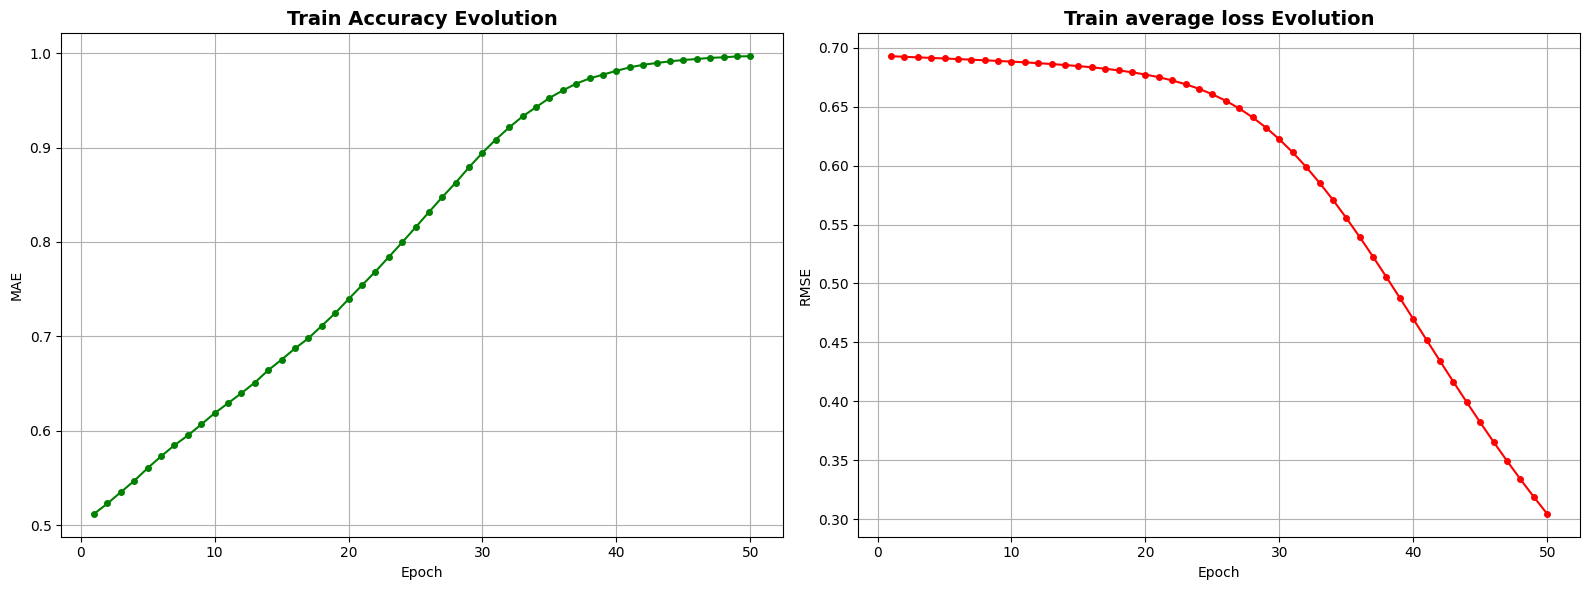

In [17]:
# Plotting Loss and accuracy over epochs
plt.figure(figsize=(16, 6))


# Plotting MAE
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), accuracy_evolution, marker='o', color='g', label="accuracy",markersize=4)
plt.title('Train Accuracy Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

# Plotting RMSE
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), average_loss_evolution, marker='o', color='r', label="average loss",markersize=4)
plt.title('Train average loss Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(True)


plt.tight_layout()
plt.show()

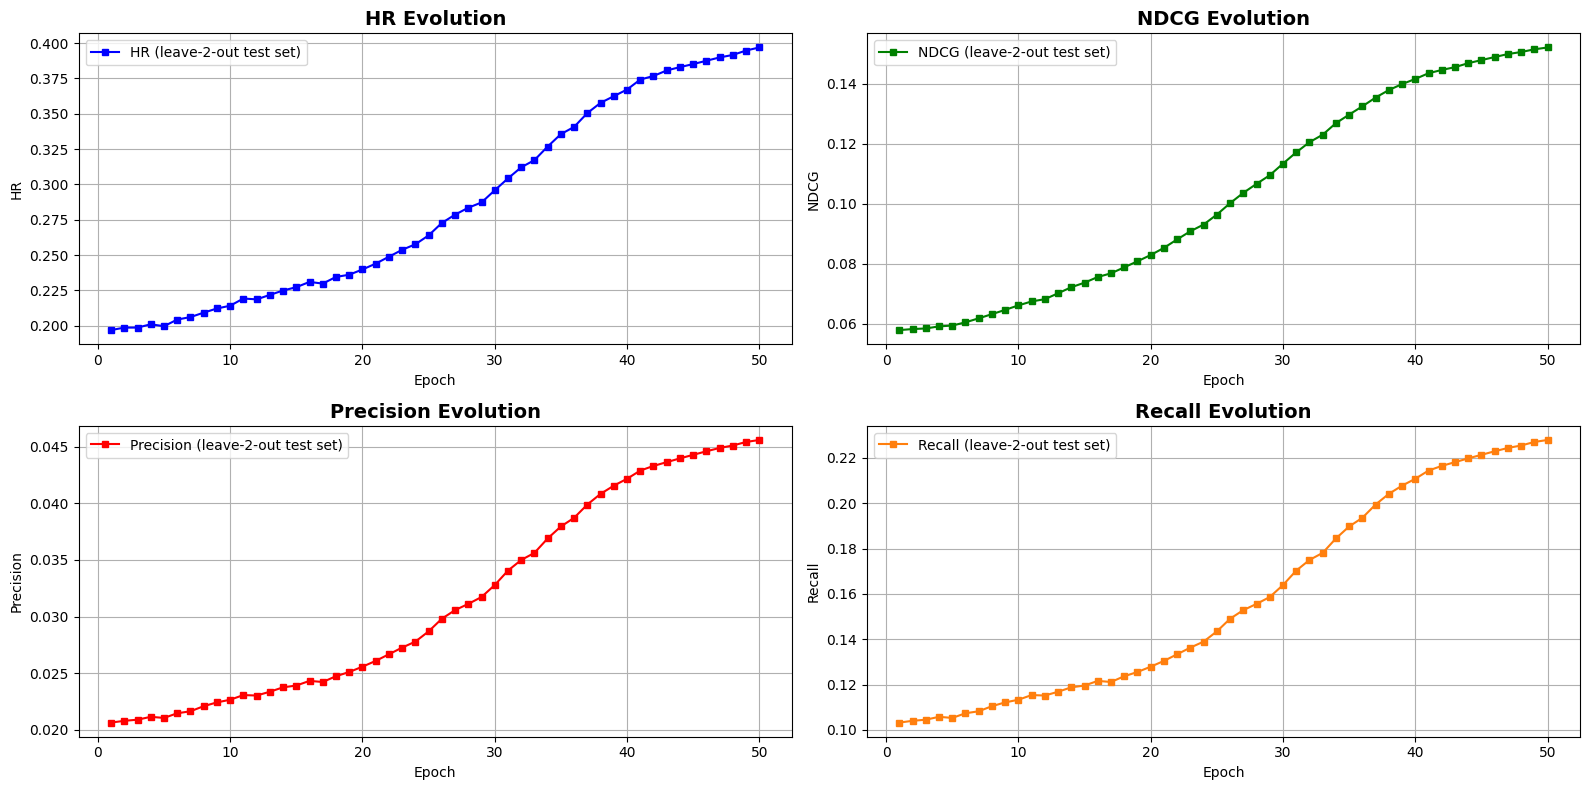

In [19]:
plt.figure(figsize=(16, 8))

# HR Evolution
plt.subplot(2, 2, 1) 
plt.plot(range(1, num_epochs + 1), hr_evolution, marker='s', color='b', label="HR (leave-2-out test set)", markersize=4)
plt.title('HR Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('HR')
plt.grid(True)
plt.legend()

# NDCG Evolution
plt.subplot(2, 2, 2) 
plt.plot(range(1, num_epochs + 1), ndcg_evolution, marker='s', color='g', label="NDCG (leave-2-out test set)", markersize=4)
plt.title('NDCG Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('NDCG')
plt.grid(True)
plt.legend()

# Precision Evolution
plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs + 1), precision_evolution, marker='s', color='r', label="Precision (leave-2-out test set)", markersize=4)
plt.title('Precision Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()

# Recall Evolution
plt.subplot(2, 2, 4)  
plt.plot(range(1, num_epochs + 1), recall_evolution, marker='s', color='#ff7f0e', label="Recall (leave-2-out test set)", markersize=4)
plt.title('Recall Evolution', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### **Evaluation : (test set) accuracy**

In [22]:
# After training the model, evaluation using test_data
hr, ndcg, precision, recall = evaluate.evaluate_metrics(test, P, Q, user_id_map, item_id_map, K=K)

print("="*50)
print(" Résultats de l'évaluation du modèle ".center(50, "="))
print(f"Hit Rate (HR):      {hr:.4f}")
print(f"NDCG:               {ndcg:.4f}")
print(f"Precision:          {precision:.4f}")
print(f"Recall:             {recall:.4f}")
print("="*50)



====== Résultats de l'évaluation du modèle =======
Hit Rate (HR):      0.3969
NDCG:               0.1521
Precision:          0.0456
Recall:             0.2279
